Groupby is an extremly useful operation.

The general form is

1. Split a table
2. Apply an operation to each chunk
3. Combine the results



In [1]:
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 10

In [4]:
!head -n 20 ../data/beeradvocate.txt

beer/name: Sausa Weizen
beer/beerId: 47986
beer/brewerId: 10325
beer/ABV: 5.00
beer/style: Hefeweizen
review/appearance: 2.5
review/aroma: 2
review/palate: 1.5
review/taste: 1.5
review/overall: 1.5
review/time: 1234817823
review/profileName: stcules
review/text: A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.		

beer/name: Red Moon
beer/beerId: 48213
beer/brewerId: 10325
beer/ABV: 6.20
beer/style: English Strong Ale
review/appearance: 3


This is *subset* of the data from beeradvocate, via [Standford](https://snap.stanford.edu/data/web-RateBeer.html). It's strangely formatted.

```
beer/name: Sausa Weizen
beer/beerId: 47986
beer/brewerId: 10325
beer/ABV: 5.00
beer/style: Hefeweizen
review/appearance: 2.5
review/aroma: 2
review/palate: 1.5
review/taste: 1.5
review/overall: 1.5
review/time: 1234817823
review/profileName: stcules
review/text: A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.		

beer/name: Red Moon
beer/beerId: 48213
beer/brewerId: 10325
beer/ABV: 6.20
 ...
```

We parse them in chunks.

```python
def format_review(review):
    return dict(map(lambda x: x.strip().split(":", 1), review))

def as_dataframe(reviews):
    col_names = {
        'beer/ABV': 'abv', 'beer/beerId': 'beer_id', 'beer/brewerId': 'brewer_id',
        'beer/name': 'beer_name', 'beer/style': 'beer_style',
        'review/appearance': 'review_appearance', 'review/aroma': 'review_aroma',
        'review/overall': 'review_overall', 'review/palate': 'review_palate',
        'review/profileName': 'profile_name', 'review/taste': 'review_taste',
        'review/text': 'text', 'review/time': 'time'
    }
    df = pd.DataFrame(list(reviews))
    numeric = ['abv', 'review_appearance', 'review_aroma',
               'review_overall', 'review_palate', 'review_taste']
    df = (df.rename(columns=col_names)
            .replace('', np.nan))
    df[numeric] = df[numeric].astype(float)
    df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
    return df

def main():
    with open('beeradvocate.txt') as f:
        reviews = filter(lambda x: x != ('\n',),
                         partitionby(lambda x: x == '\n', f))
        reviews = map(format_review, reviews)
        reviews = partition(100000, reviews, pad=None)
        reviews = filter(None, reviews)
        os.makedirs('beer_reviews', exist_ok=True)

        for i, subset in enumerate(reviews):
            print(i, end='\r')
            df = as_dataframe(subset)
            df.to_csv('beer_reviews/review_%s.csv' % i, index=False)
```



To select this subset, the first 10th of the reviews (by time), I used [`dask`](http://dask.readthedocs.org).

```python
import dask.dataframe as dd

In [1]: df = pd.read_csv('beer_review/*.csv', parse_dates=['time'])
In [2]: cutoff = df.time.quantiles([10]).compute()[0]
In [3]: %time subset = df[df.time < cutoff].compute()
CPU times: user 20.8 s, sys: 6.93 s, total: 27.8 s
Wall time: 27.1 s```

All of those files wouldn't fit in memory at once. But we can compute quantiles.

```python
subset.sort('time').to_csv('subset.csv')
```

In [15]:
df = pd.read_csv('../data/beer_subset.csv', parse_dates=['time'])
strcols = ['beer_name', 'beer_style', 'profile_name']
df[strcols] = df[strcols].apply(lambda x: x.str.strip())

# A bit of EDA

In [16]:
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']


In [26]:
df.head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,5.3,93,33,Steel Rail Extra Pale Ale,American Pale Ale (APA),3.5,3.5,4.0,4.0,Todd,4.0,"Presentation: Pint size, on tap from the East...",1996-08-22 00:00:01
1,17.5,111,35,Samuel Adams Triple Bock,American Strong Ale,3.0,4.0,4.0,4.5,Todd,4.5,Presentation: 8.45oz blue bottle with gold le...,1998-01-10 00:00:01
2,5.0,97,144,Special Amber,Vienna Lager,4.0,4.0,4.5,4.0,BeerAdvocate,4.0,Presentation: It is so pleasing to obtain bee...,1998-01-13 00:00:01
3,4.8,51,139,Tremont Ale,English Pale Ale,3.0,3.5,4.0,3.5,BeerAdvocate,4.0,Presentation: Bottle and six-pack carrier hav...,1998-01-21 00:00:01
4,NaN,306,138,Casey's Smooth Stout,Irish Dry Stout,3.0,3.0,1.0,1.0,BeerAdvocate,1.0,Presentation: 12oz. green bottle.\t\tAppearan...,1998-01-22 00:00:01


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
abv                  91159 non-null float64
beer_id              100000 non-null int64
brewer_id            100000 non-null int64
beer_name            100000 non-null object
beer_style           100000 non-null object
review_appearance    100000 non-null float64
review_aroma         100000 non-null float64
review_overall       100000 non-null float64
review_palate        100000 non-null float64
profile_name         99990 non-null object
review_taste         100000 non-null float64
text                 100000 non-null object
time                 100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(2), object(4)
memory usage: 10.7+ MB


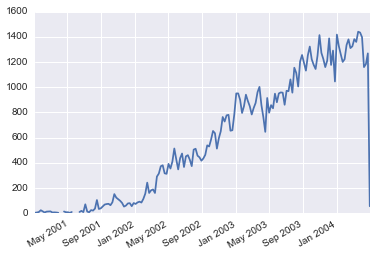

In [28]:
df.time.value_counts().resample('7d', how='sum').loc['2001':].plot()

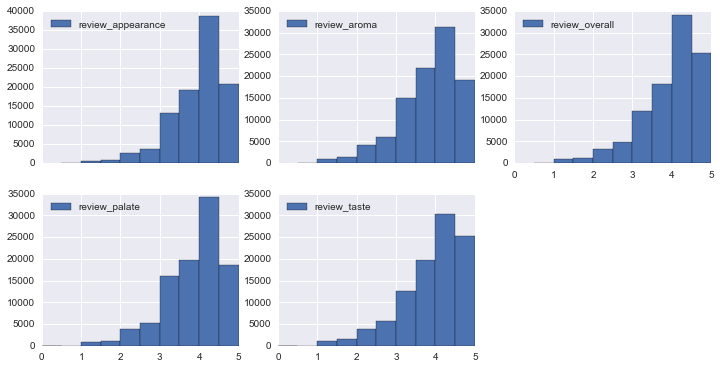

In [39]:
axes = df[review_cols].plot(kind='hist', subplots=True, layout=(2, 3), figsize=(12, 6))
[ax.set_ylabel('') for ax in axes.ravel()]

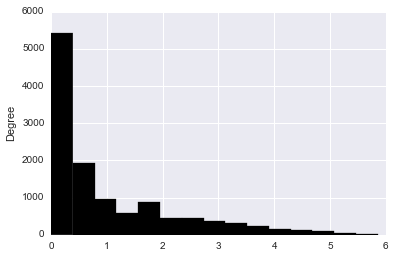

In [44]:
np.log(df.beer_id.value_counts()).plot(kind='hist', bins=15, color='k')

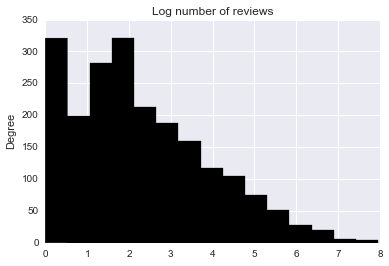

In [45]:
ax = np.log(df.brewer_id.value_counts()).plot(kind='hist', bins=15, color='k')
ax.set_title("Log number of reviews")

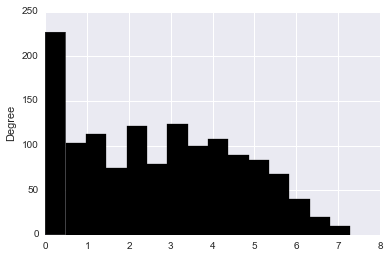

In [46]:
df.profile_name.value_counts().pipe(np.log).plot(kind='hist', bins=15, color='k')

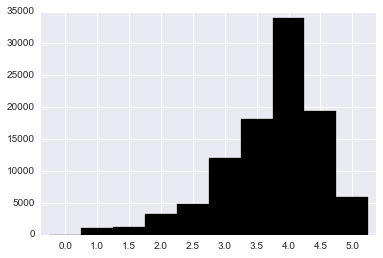

In [49]:
df.review_overall.value_counts().sort_index().plot(kind='bar', width=1, color='k', rot=0)

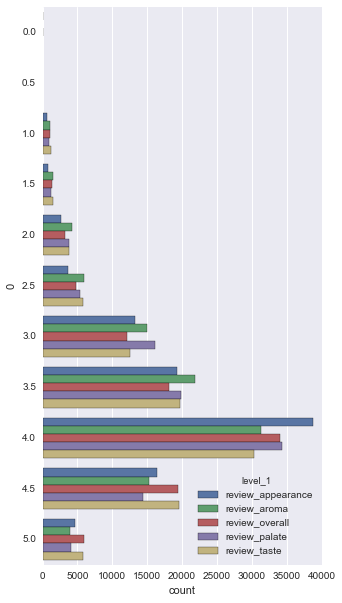

In [50]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.countplot(hue='level_1', y=0, data=df[review_cols].stack().reset_index(level=1), ax=ax,
              order=np.arange(0, 5.5, .5))

# Groupby

In [51]:
df.groupby?

```python
df.groupby( grouper )
```

`grouper` can be many things

- Series (or string indicating a column in `df`)
- function (to be applied on the index)
- dict : *values*
- `levels=[]`, names of levels in a MultiIndex

In [53]:
gr = df.groupby('beer_style')
gr

Haven't really done anything yet. Just some book-keeping.

We can select a column (`review_aroma`) and apply a function (`mean`).

In [56]:
gr['review_aroma'].mean().order(ascending=False)

beer_style
American Black Ale                 4.500000
Bière de Champagne / Bière Brut    4.364865
American Double / Imperial IPA     4.281613
Eisbock                            4.246341
Quadrupel (Quad)                   4.240573
                                     ...   
American Adjunct Lager             2.343875
Low Alcohol Beer                   2.331395
Happoshu                           2.148148
American Malt Liquor               2.134181
Light Lager                        2.054418
Name: review_aroma, dtype: float64

Multiple Aggregations on one column

In [57]:
gr['review_aroma'].agg(['mean', 'std', 'count']).head()

,mean,std,count
beer_style,,,
Altbier,3.638808,0.613997,688
American Adjunct Lager,2.343875,0.732937,4000
American Amber / Red Ale,3.599936,0.622295,3137
American Amber / Red Lager,3.078645,0.677906,782
American Barleywine,4.141017,0.526547,1475


In [59]:
gr['review_aroma'].agg([np.mean, np.std, 'count']).head()

,mean,std,count
beer_style,,,
Altbier,3.638808,0.613997,688
American Adjunct Lager,2.343875,0.732937,4000
American Amber / Red Ale,3.599936,0.622295,3137
American Amber / Red Lager,3.078645,0.677906,782
American Barleywine,4.141017,0.526547,1475


Single Aggregation on multiple columns

In [60]:
gr[review_cols].mean()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_style,,,,,
Altbier,3.807413,3.638808,3.846657,3.715843,3.778343
American Adjunct Lager,2.625375,2.343875,2.815625,2.547625,2.520250
American Amber / Red Ale,3.783392,3.599936,3.774944,3.614759,3.693178
American Amber / Red Lager,3.434143,3.078645,3.403453,3.169437,3.223146
American Barleywine,4.085763,4.141017,3.968136,4.124068,4.156271
...,...,...,...,...,...
Vienna Lager,3.692754,3.461353,3.746377,3.561353,3.622705
Weizenbock,4.080000,4.098000,4.090000,4.075000,4.205000
Wheatwine,4.063492,4.126984,4.087302,4.103175,4.246032


Multiple aggregations on multiple columns

In [61]:
gr[review_cols].agg(['mean', 'count', 'std'])

review_appearance                 review_aroma  \
                                        mean count       std         mean   
beer_style                                                                  
Altbier                             3.807413   688  0.510062     3.638808   
American Adjunct Lager              2.625375  4000  0.740510     2.343875   
American Amber / Red Ale            3.783392  3137  0.550992     3.599936   
American Amber / Red Lager          3.434143   782  0.611309     3.078645   
American Barleywine                 4.085763  1475  0.487219     4.141017   
...                                      ...   ...       ...          ...   
Vienna Lager                        3.692754  1035  0.547365     3.461353   
Weizenbock                          4.080000   500  0.488956     4.098000   
Wheatwine                           4.063492    63  0.406520     4.126984   
Winter Warmer                       3.909091  2090  0.509708     3.806220   
Witbier                             3.757968  1663  0.601008     3.732111   

                                           review_overall                  \
                           count       std           mean count       std   
beer_style                                                                  
Altbier                      688  0.613997       3.846657   688  0.669107   
American Adjunct Lager      4000  0.732937       2.815625  4000  0.907758   
American Amber / Red Ale    3137  0.622295       3.774944  3137  0.667224   
American Amber / Red Lager   782  0.677906       3.403453   782  0.839914   
American Barleywine         1475  0.526547       3.968136  1475  0.632939   
...                          ...       ...            ...   ...       ...   
Vienna Lager                1035  0.610161       3.746377  1035  0.673966   
Weizenbock                   500  0.566602       4.090000   500  0.647099   
Wheatwine                     63  0.538578       4.087302    63  0.585715   
Winter Warmer               2090  0.613600       3.772967  2090  0.656201   
Witbier                     1663  0.637952       3.879134  1663  0.751935   

                           review_palate                 review_taste        \
                                    mean count       std         mean count   
beer_style                                                                    
Altbier                         3.715843   688  0.628875     3.778343   688   
American Adjunct Lager          2.547625  4000  0.778746     2.520250  4000   
American Amber / Red Ale        3.614759  3137  0.612291     3.693178  3137   
American Amber / Red Lager      3.169437   782  0.731843     3.223146   782   
American Barleywine             4.124068  1475  0.556688     4.156271  1475   
...                                  ...   ...       ...          ...   ...   
Vienna Lager                    3.561353  1035  0.646635     3.622705  1035   
Weizenbock                      4.075000   500  0.587849     4.205000   500   
Wheatwine                       4.103175    63  0.484924     4.246032    63   
Winter Warmer                   3.738517  2090  0.612558     3.808134  2090   
Witbier                         3.702044  1663  0.642748     3.755262  1663   

                                      
                                 std  
beer_style                            
Altbier                     0.659106  
American Adjunct Lager      0.806227  
American Amber / Red Ale    0.658281  
American Amber / Red Lager  0.780124  
American Barleywine         0.609863  
...                              ...  
Vienna Lager                0.663658  
Weizenbock                  0.669606  
Wheatwine                   0.506992  
Winter Warmer               0.664371  
Witbier                     0.721590  

[103 rows x 15 columns]

Hierarchical Indexes in the columns can be awkward to work with.

In [62]:
gr[review_cols].agg(['mean', 'count', 'std']).stack(level=0)

mean  count       std
beer_style                                             
Altbier    review_appearance  3.807413    688  0.510062
           review_aroma       3.638808    688  0.613997
           review_overall     3.846657    688  0.669107
           review_palate      3.715843    688  0.628875
           review_taste       3.778343    688  0.659106
...                                ...    ...       ...
Witbier    review_appearance  3.757968   1663  0.601008
           review_aroma       3.732111   1663  0.637952
           review_overall     3.879134   1663  0.751935
           review_palate      3.702044   1663  0.642748
           review_taste       3.755262   1663  0.721590

[515 rows x 3 columns]

Group by multiple columns

In [63]:
df.groupby(['brewer_id', 'beer_style']).review_overall.mean()

brewer_id  beer_style                    
1          Czech Pilsener                    3.821596
2          American Blonde Ale               3.750000
           American Dark Wheat Ale           2.285714
           American IPA                      4.166667
           American Pale Ale (APA)           4.250000
                                               ...   
23980      Light Lager                       3.145161
24926      Belgian Strong Dark Ale           3.593750
           Fruit / Vegetable Beer            3.800000
24964      American Malt Liquor              3.227273
27039      American Double / Imperial IPA    4.500000
Name: review_overall, dtype: float64

In [229]:
avg = df.query('beer_id in @top_beers').groupby('beer_name')['review_aroma', 'review_overall'].mean()
(avg.review_overall - avg.review_aroma).idxmax()

'Miller High Life'

In [227]:
df[df.beer_name == "Miller High Life"]

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
459,5,580,105,Miller High Life,American Adjunct Lager,1.0,2.0,2.0,2.0,grdahl,2.0,Miller Low Life..The Champangne of Beers?? Th...,2001-06-22 23:04:35
587,5,580,105,Miller High Life,American Adjunct Lager,3.0,2.0,3.0,2.0,Brent,3.0,Always strikes me as sweet and grainy. At le...,2001-07-31 09:30:40
1080,5,580,105,Miller High Life,American Adjunct Lager,2.0,2.0,4.0,3.5,xXTequila,4.0,Latley this is the beer that I have been stoc...,2001-10-03 13:16:19
1621,5,580,105,Miller High Life,American Adjunct Lager,2.0,2.0,2.0,1.0,beerluvr,2.0,"Although it's been years since I've had one, ...",2001-11-07 21:06:03
1755,5,580,105,Miller High Life,American Adjunct Lager,1.0,1.0,2.0,2.0,Jordan,2.0,Horse piss in a bottle. But it's cheap! Rem...,2001-11-18 08:27:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98190,5,580,105,Miller High Life,American Adjunct Lager,4.0,3.0,4.0,2.0,granger10,3.5,I can't believe I haven't reviewed this beer ...,2004-04-18 23:54:03
98347,5,580,105,Miller High Life,American Adjunct Lager,2.5,2.5,3.5,3.0,Southernbrew,3.5,"Piss yellow, decent head.\t\tSome corn and gr...",2004-04-19 23:15:16
99495,5,580,105,Miller High Life,American Adjunct Lager,4.0,3.0,3.5,3.0,DPMomutant,2.5,"A light golden yellow as per most American ""m...",2004-04-26 06:59:42
99850,5,580,105,Miller High Life,American Adjunct Lager,3.0,2.5,4.0,4.0,GIVEMEBACKMYSON,3.5,I've drank too many of this beer to have not ...,2004-04-28 14:32:56


In [64]:
df.groupby(['brewer_id', 'beer_style'])[review_cols].mean()

review_appearance  review_aroma  \
brewer_id beer_style                                                        
1         Czech Pilsener                           3.781690      3.422535   
2         American Blonde Ale                      3.250000      3.750000   
          American Dark Wheat Ale                  3.071429      2.428571   
          American IPA                             3.833333      4.000000   
          American Pale Ale (APA)                  4.000000      4.000000   
...                                                     ...           ...   
23980     Light Lager                              2.870968      2.564516   
24926     Belgian Strong Dark Ale                  3.843750      3.812500   
          Fruit / Vegetable Beer                   4.200000      4.400000   
24964     American Malt Liquor                     2.954545      2.772727   
27039     American Double / Imperial IPA           4.333333      4.500000   

                                          review_overall  review_palate  \
brewer_id beer_style                                                      
1         Czech Pilsener                        3.821596       3.624413   
2         American Blonde Ale                   3.750000       3.500000   
          American Dark Wheat Ale               2.285714       2.357143   
          American IPA                          4.166667       4.166667   
          American Pale Ale (APA)               4.250000       4.000000   
...                                                  ...            ...   
23980     Light Lager                           3.145161       2.661290   
24926     Belgian Strong Dark Ale               3.593750       3.750000   
          Fruit / Vegetable Beer                3.800000       3.400000   
24964     American Malt Liquor                  3.227273       2.954545   
27039     American Double / Imperial IPA        4.500000       4.666667   

                                          review_taste  
brewer_id beer_style                                    
1         Czech Pilsener                      3.650235  
2         American Blonde Ale                 3.500000  
          American Dark Wheat Ale             2.285714  
          American IPA                        4.166667  
          American Pale Ale (APA)             4.000000  
...                                                ...  
23980     Light Lager                         2.741935  
24926     Belgian Strong Dark Ale             3.750000  
          Fruit / Vegetable Beer              3.900000  
24964     American Malt Liquor                2.954545  
27039     American Double / Imperial IPA      4.666667  

[9862 rows x 5 columns]

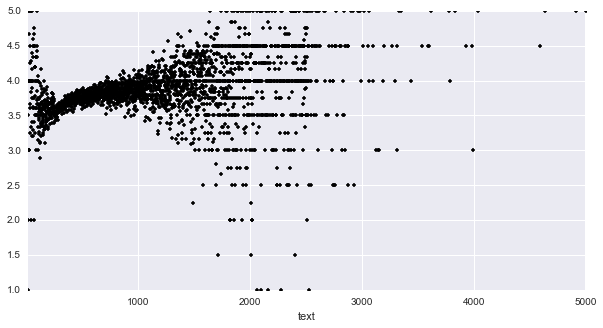

In [74]:
df.groupby(df.text.str.len()).review_overall.mean().plot(style='.k', figsize=(10, 5))

# Recommender

In [67]:
style = df.beer_style

In [68]:
style.replace({
    'india pale ale': 'ipa',
    'american pale ale': 'apa'
})

0        American Pale Ale (APA)
1            American Strong Ale
2                   Vienna Lager
3               English Pale Ale
4                Irish Dry Stout
                  ...           
99995          English Brown Ale
99996                    Old Ale
99997              Baltic Porter
99998                 Doppelbock
99999     Scotch Ale / Wee Heavy
Name: beer_style, dtype: object

In [75]:
kinds = ['ipa', 'apa', 'amber ale', 'rye', 'scotch', 'stout', 'barleywine', 'porter', 'brown ale', 'lager', 'pilsner',
         'tripel', 'biter', 'farmhouse', 'malt liquour', 'rice']

In [76]:
expr = '|'.join(['(?P<{name}>{pat})'.format(pat=kind, name=kind.replace(' ', '_')) for kind in kinds])
expr

'(?P<ipa>ipa)|(?P<apa>apa)|(?P<amber_ale>amber ale)|(?P<rye>rye)|(?P<scotch>scotch)|(?P<stout>stout)|(?P<barleywine>barleywine)|(?P<porter>porter)|(?P<brown_ale>brown ale)|(?P<lager>lager)|(?P<pilsner>pilsner)|(?P<tripel>tripel)|(?P<biter>biter)|(?P<farmhouse>farmhouse)|(?P<malt_liquour>malt liquour)|(?P<rice>rice)'

In [77]:
style.str.replace('India Pale Ale', 'IPA')

0        American Pale Ale (APA)
1            American Strong Ale
2                   Vienna Lager
3               English Pale Ale
4                Irish Dry Stout
                  ...           
99995          English Brown Ale
99996                    Old Ale
99997              Baltic Porter
99998                 Doppelbock
99999     Scotch Ale / Wee Heavy
Name: beer_style, dtype: object

In [78]:
beer_kind = (style.replace({
    'india pale ale': 'ipa',
    'american pale ale': 'apa'
})
 .str.extract(expr, flags=re.IGNORECASE).fillna('').sum(1)
 .str.lower().replace('', 'other')
)

In [79]:
df.groupby(['brewer_id', beer_kind]).review_overall.mean()

brewer_id           
1          other        3.821596
2          apa          4.250000
           brown ale    3.500000
           ipa          4.166667
           other        2.666667
                          ...   
23980      other        3.630435
           porter       3.788889
24926      other        3.642857
24964      other        3.227273
27039      ipa          4.500000
Name: review_overall, dtype: float64

# Transform

In [80]:
by_user = df.groupby('profile_name')
by_user[review_cols].mean().std()

review_appearance    0.497147
review_aroma         0.559803
review_overall       0.525185
review_palate        0.530642
review_taste         0.596528
dtype: float64

In [81]:
def standardize(x):
    s = (x - x.mean()) / x.std()
    return s

Can't do it on everyone since some people have 1 review, so 0 variance.

In [82]:
user_counts = df.profile_name.value_counts()
top_users = user_counts[user_counts > user_counts.quantile(.8)].index

In [83]:
top_users

Index(['Gusler', 'beerguy101', 'Jason', 'NeroFiddled', 'rastaman',
       'feloniousmonk', 'Bighuge', 'marc77', 'ImperialScott', 'Dogbrick', 
       ...
       'ThreePistols', 'rabidawg', 'Rifrafboy', 'jlervine', 'Reverand', 'byrd',
       'Imbiber', 'SeanLassiter', 'Dantes', 'wolfy'],
      dtype='object', length=271)

In [84]:
by_profile = df[df.profile_name.isin(top_users)].groupby('profile_name')
by_profile[review_cols].transform(standardize)

,review_appearance,review_aroma,review_overall,review_palate,review_taste
0,-0.191295,0.000000,0.237258,0.472812,0.298992
1,-0.922972,0.726722,0.237258,1.109180,0.865988
2,0.687126,0.582539,0.995261,0.439697,0.016407
3,-1.047049,-0.482101,0.036191,-0.445263,0.016407
4,-1.047049,-1.546742,-5.718229,-4.870061,-5.201129
...,...,...,...,...,...
99994,0.221821,0.290897,0.108014,0.290537,0.838739
99996,0.204634,-0.572207,-0.679238,-0.775828,0.426845
99997,0.221821,0.290897,0.108014,1.027016,0.124500
99998,0.848578,0.773989,0.493364,1.797813,0.599961


In [85]:
style_counts = df.beer_style.value_counts()
top_styles = style_counts[style_counts > 1000].index
top_styles

Index(['American Pale Ale (APA)', 'American IPA', 'American Adjunct Lager',
       'American Porter', 'American Amber / Red Ale', 'Hefeweizen',
       'English Pale Ale', 'Euro Pale Lager', 'Fruit / Vegetable Beer',
       'Belgian Strong Dark Ale', 'Belgian Strong Pale Ale', 'German Pilsener',
       'Winter Warmer', 'English Brown Ale', 'Märzen / Oktoberfest',
       'Doppelbock', 'Tripel', 'Extra Special / Strong Bitter (ESB)',
       'Russian Imperial Stout', 'Oatmeal Stout', 'Light Lager',
       'American Stout', 'Witbier', 'American Barleywine', 'Irish Dry Stout',
       'American Double / Imperial IPA', 'American Pale Wheat Ale', 'Dubbel',
       'English India Pale Ale (IPA)', 'Belgian Pale Ale',
       'American Strong Ale', 'American Blonde Ale', 'Czech Pilsener',
       'Vienna Lager', 'Milk / Sweet Stout', 'Munich Dunkel Lager'],
      dtype='object')

In [86]:
df.query('beer_style in @top_styles').groupby('beer_style')[review_cols].std().sort('review_overall', ascending=False)

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_style,,,,,
Light Lager,0.853114,0.789250,0.980983,0.850025,0.860118
American Adjunct Lager,0.740510,0.732937,0.907758,0.778746,0.806227
Fruit / Vegetable Beer,0.681960,0.796499,0.870732,0.766959,0.882733
Euro Pale Lager,0.655138,0.711215,0.805289,0.704868,0.760683
American Strong Ale,0.555619,0.657642,0.792216,0.668799,0.727868
...,...,...,...,...,...
Belgian Strong Dark Ale,0.523263,0.546544,0.632061,0.573396,0.598571
Oatmeal Stout,0.515512,0.549528,0.601426,0.626137,0.617185
Tripel,0.520939,0.543035,0.600871,0.551631,0.593174


# Aside: Beer Recommender

In [87]:
by_brewer = df.groupby(['brewer_id', 'beer_style']).review_overall.agg(['count', 'mean'])

Select brewers with many types of styles

In [88]:
by_brewer.loc[by_brewer['count'] > 10, 'mean'].unstack()

beer_style,Altbier,American Adjunct Lager,American Amber / Red Ale,American Amber / Red Lager,American Barleywine,American Blonde Ale,American Brown Ale,American Dark Wheat Ale,American Double / Imperial IPA,American Double / Imperial Pilsner,...,Scotch Ale / Wee Heavy,Scottish Ale,Scottish Gruit / Ancient Herbed Ale,Smoked Beer,Tripel,Vienna Lager,Weizenbock,Wheatwine,Winter Warmer,Witbier
brewer_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,3.222222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.570312,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.2,NaN,NaN,NaN,NaN,4.159864
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.36,NaN,NaN,NaN,NaN,NaN,NaN,3.866667,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18639,NaN,NaN,3.909091,NaN,NaN,3.955882,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23980,NaN,NaN,NaN,3.726974,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


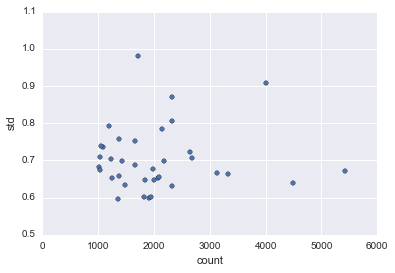

In [89]:
(df.query('beer_style in @top_styles')
    .groupby('beer_style')
    .review_overall
    .agg(['count', 'std'])
    .plot(kind='scatter', x='count', y='std'))

In [150]:
x = df.set_index(['profile_name', 'brewer_id', 'beer_id', 'time']).sort_index()

In [154]:
x.loc[('BeerAdvocate', 141, 181, slice(None)), :]

abv  \
profile_name brewer_id beer_id time                       
BeerAdvocate 141       181     1999-02-04 00:00:01   10   
                               1999-02-04 00:00:01   10   

                                                                                            beer_name  \
profile_name brewer_id beer_id time                                                                     
BeerAdvocate 141       181     1999-02-04 00:00:01  Smuttynose Barleywine Style Ale (Big Beer Series)   
                               1999-02-04 00:00:01  Smuttynose Barleywine Style Ale (Big Beer Series)   

                                                             beer_style  \
profile_name brewer_id beer_id time                                       
BeerAdvocate 141       181     1999-02-04 00:00:01  American Barleywine   
                               1999-02-04 00:00:01  American Barleywine   

                                                    review_appearance  \
profile_name brewer_id beer_id time                                     
BeerAdvocate 141       181     1999-02-04 00:00:01                3.5   
                               1999-02-04 00:00:01                3.5   

                                                    review_aroma  \
profile_name brewer_id beer_id time                                
BeerAdvocate 141       181     1999-02-04 00:00:01             4   
                               1999-02-04 00:00:01             4   

                                                    review_overall  \
profile_name brewer_id beer_id time                                  
BeerAdvocate 141       181     1999-02-04 00:00:01             3.5   
                               1999-02-04 00:00:01             4.5   

                                                    review_palate  \
profile_name brewer_id beer_id time                                 
BeerAdvocate 141       181     1999-02-04 00:00:01            4.0   
                               1999-02-04 00:00:01            4.5   

                                                    review_taste  \
profile_name brewer_id beer_id time                                
BeerAdvocate 141       181     1999-02-04 00:00:01           4.0   
                               1999-02-04 00:00:01           4.5   

                                                                                                 text  
profile_name brewer_id beer_id time                                                                    
BeerAdvocate 141       181     1999-02-04 00:00:01   Presentation: On-tap.\t\tAppearance: Deep haz...  
                               1999-02-04 00:00:01   Presentation: 750ml brown with a Victorian st...

In [158]:
x = x.groupby(level=x.index.names).first()

In [174]:
beer_ids = x.index.get_level_values(1).value_counts().head(15).index

In [192]:
sub = x.loc[(slice(None), slice(None), beer_ids, slice(None)), :].review_overall
ts = sub.groupby(level=['beer_id', 'time']).mean().unstack('beer_id')

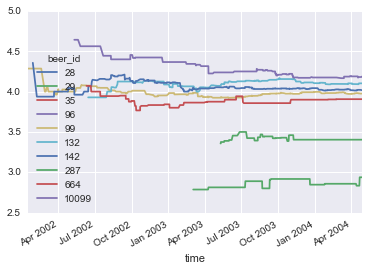

In [195]:
pd.expanding_mean(ts, min_periods=7).loc['2002':].plot()

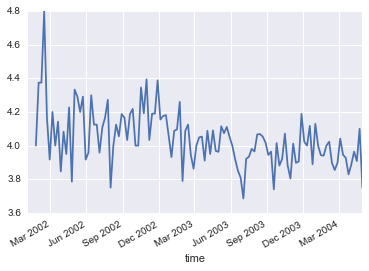

In [170]:
x.xs(132, level=1).groupby(level='time').review_aroma.mean().resample('7d').loc['2002':].plot()

In [151]:
x[x.index.duplicated()]

abv  \
profile_name brewer_id beer_id time                        
BeerAdvocate 141       181     1999-02-04 00:00:01  10.0   
             9343      538     1999-07-27 00:00:01   5.5   
                       556     1998-05-12 00:00:01   5.2   
stephenlouis 4724      12507   2003-09-04 23:50:00   5.5   

                                                                                            beer_name  \
profile_name brewer_id beer_id time                                                                     
BeerAdvocate 141       181     1999-02-04 00:00:01  Smuttynose Barleywine Style Ale (Big Beer Series)   
             9343      538     1999-07-27 00:00:01                                    Fenway Pale Ale   
                       556     1998-05-12 00:00:01                                         Boston Red   
stephenlouis 4724      12507   2003-09-04 23:50:00                                 Salt Spring Porter   

                                                                  beer_style  \
profile_name brewer_id beer_id time                                            
BeerAdvocate 141       181     1999-02-04 00:00:01       American Barleywine   
             9343      538     1999-07-27 00:00:01   American Pale Ale (APA)   
                       556     1998-05-12 00:00:01  American Amber / Red Ale   
stephenlouis 4724      12507   2003-09-04 23:50:00           American Porter   

                                                    review_appearance  \
profile_name brewer_id beer_id time                                     
BeerAdvocate 141       181     1999-02-04 00:00:01                3.5   
             9343      538     1999-07-27 00:00:01                3.0   
                       556     1998-05-12 00:00:01                3.5   
stephenlouis 4724      12507   2003-09-04 23:50:00                4.0   

                                                    review_aroma  \
profile_name brewer_id beer_id time                                
BeerAdvocate 141       181     1999-02-04 00:00:01           4.0   
             9343      538     1999-07-27 00:00:01           4.0   
                       556     1998-05-12 00:00:01           3.5   
stephenlouis 4724      12507   2003-09-04 23:50:00           3.5   

                                                    review_overall  \
profile_name brewer_id beer_id time                                  
BeerAdvocate 141       181     1999-02-04 00:00:01             4.5   
             9343      538     1999-07-27 00:00:01             4.0   
                       556     1998-05-12 00:00:01             4.0   
stephenlouis 4724      12507   2003-09-04 23:50:00             3.0   

                                                    review_palate  \
profile_name brewer_id beer_id time                                 
BeerAdvocate 141       181     1999-02-04 00:00:01            4.5   
             9343      538     1999-07-27 00:00:01            4.0   
                       556     1998-05-12 00:00:01            3.5   
stephenlouis 4724      12507   2003-09-04 23:50:00            3.5   

                                                    review_taste  \
profile_name brewer_id beer_id time                                
BeerAdvocate 141       181     1999-02-04 00:00:01           4.5   
             9343      538     1999-07-27 00:00:01           4.0   
                       556     1998-05-12 00:00:01           3.5   
stephenlouis 4724      12507   2003-09-04 23:50:00           4.0   

                                                                                                 text  
profile_name brewer_id beer_id time                                                                    
BeerAdvocate 141       181     1999-02-04 00:00:01   Presentation: 750ml brown with a Victorian st...  
             9343      538     1999-07-27 00:00:01   Presentation: On tap.\t\tAppearance: Clear am...  
                       556     1998-05-12 00:00:01   Presentation: On c

# Top Users

In [91]:
user_means = df.groupby('profile_name')[review_cols].mean()
brewer_means = df.groupby('brewer_id')[review_cols].mean()
overall_means = df[review_cols].mean()

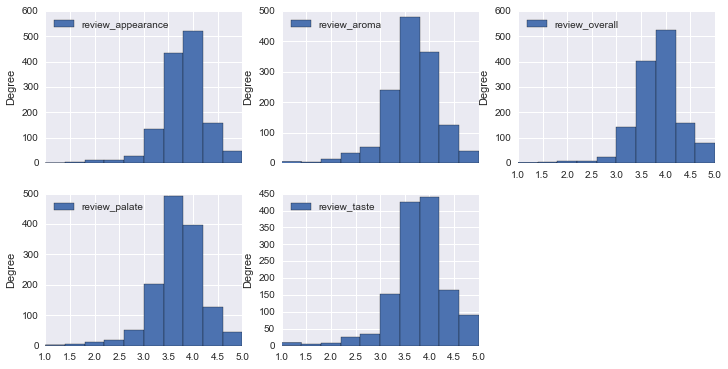

In [92]:
user_means.plot(kind='hist', subplots=True, layout=(2, 3), figsize=(12, 6));

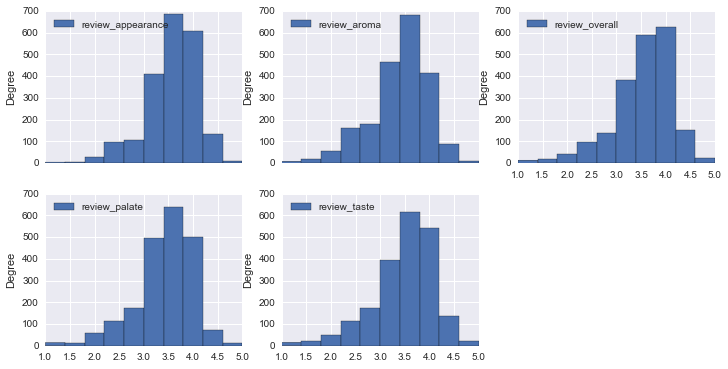

In [93]:
brewer_means.plot(kind='hist', subplots=True, layout=(2, 3), figsize=(12, 6));

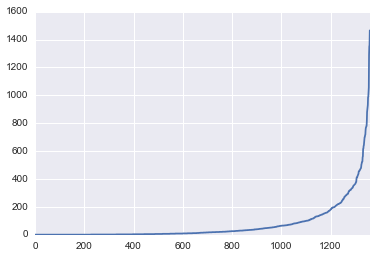

In [94]:
df.profile_name.value_counts().order().plot(use_index=False)

In [95]:
user_counts = df.profile_name.value_counts().order()
top_users = user_counts[user_counts > user_counts.quantile(.8)].index

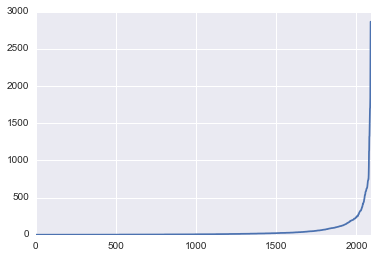

In [96]:
brewer_counts = df.brewer_id.value_counts().order().plot(use_index=False)

In [97]:
df.groupby(['beer_id', 'profile_name']).review_overall.count().max()

3

In [98]:
deduped = df.groupby(['beer_id', 'profile_name']).review_overall.mean().reset_index()
deduped.head()

,beer_id,profile_name,review_overall
0,3,Jason,4.0
1,3,MAB,4.5
2,3,Morris729,4.0
3,4,AtrumAnimus,5.0
4,4,GreenCard,3.0


In [99]:
beer_counts = deduped.beer_id.value_counts()
top_beers = beer_counts[beer_counts > beer_counts.quantile(.9)].index

In [100]:
%timeit deduped[(deduped.beer_id.isin(top_beers)) & (deduped.profile_name.isin(top_users))]

10 loops, best of 3: 22.8 ms per loop


In [101]:
%timeit deduped.query('beer_id in @top_beers and profile_name in @top_users')

10 loops, best of 3: 25 ms per loop


In [102]:
top = deduped.query('beer_id in @top_beers and profile_name in @top_users')
user_means = top.groupby('profile_name').review_overall.mean()
beer_means = top.groupby('beer_id').review_overall.mean()
overall_means = top.mean()

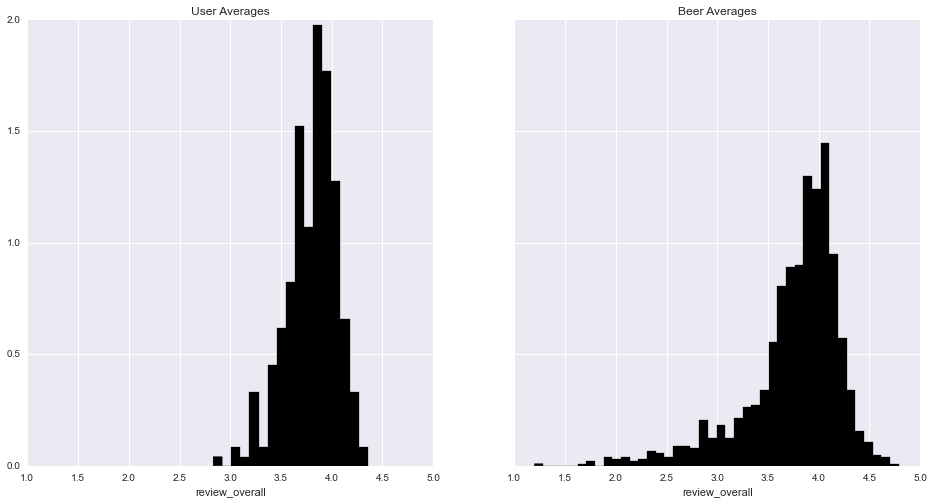

In [103]:
fig, axes = plt.subplots(figsize=(16, 8), ncols=2, sharey=True, sharex=True)

sns.distplot(user_means, kde=False, ax=axes[0], color='k', norm_hist=True, hist_kws={'alpha': 1})
sns.distplot(beer_means, kde=False, ax=axes[1], color='k', norm_hist=True, hist_kws={'alpha': 1})
axes[0].set_title("User Averages")
axes[1].set_title("Beer Averages")

In [467]:
# %%time
# beers = sorted(top.beer_id.unique())
# supports = []
# for i, beer_1 in enumerate(beers):
#     for j, beer_2 in enumerate(beers):
#         beer_1_reviewers = top[top.beer_id == beer_1].profile_name.unique()
#         beer_2_reviewers = top[top.beer_id == beer_2].profile_name.unique()
#         common_reviewers = set(beer_1_reviewers) | set(beer_2_reviewers)
#         supports.append(len(common_reviewers))

In [111]:
from scipy.stats import pearsonr

In [112]:
s = top.set_index(['beer_id', 'profile_name']).review_overall

In [113]:
s.reset_index().beer_id.value_counts()

1904     190
355      186
56973    170
276      169
92       168
        ... 
16403     13
4355      13
1882      13
3637      13
16441     12
dtype: int64

In [114]:
beer_1 = 1904
beer_2 = 276

In [115]:
reviewers_1 = s.loc[beer_1, slice(None)].index.get_level_values(1)
reviewers_2 = s.loc[beer_2, slice(None)].index.get_level_values(1)

In [116]:
common = reviewers_1 & reviewers_2

In [117]:
top.set_index(['beer_id', 'profile_name']).review_overall.loc[slice(None), common]

beer_id  profile_name
5        Beastdog75      4.0
         BeerAngel       4.0
         Boto            2.5
         Brent           4.0
         ElGuapo         4.0
                        ... 
56973    shirfan         4.0
         tavernjef       5.0
         winomark        3.5
         woemad          4.0
         xgrigorix       5.0
Name: review_overall, dtype: float64

In [200]:
from sklearn.neighbors import KDTree

In [202]:
sim

beer_1  beer_2
6       5         0.001360
7       5         0.541936
        6         0.365374
9       5         0.645497
        6         0.065164
                    ...   
56973   47785     0.327276
        48050     0.075428
        51300    -0.044591
        51558    -0.239325
        51959     0.141093
Name: score, dtype: float64

In [198]:
def simfunc(s, beer_1, beer_2, reg=4):
    n_common = len(s)
    if n_common == 0:
        return 0
    deltas = s.sub(s.groupby(level=0).mean(), level=0)
    deltas = deltas.loc[[beer_1, beer_2]].unstack(level=0)
    rho = pearsonr(deltas[beer_1], deltas[beer_2])[0]
    similarity = (n_common * rho) / (n_common + reg)
    return rho

In [199]:
def beer_similarity(s, beer_1, beer_2, simfunc=simfunc, **kwargs):
    """
    """
    reviewers_1 = s.loc[beer_1, slice(None)].index.get_level_values(1)
    reviewers_2 = s.loc[beer_2, slice(None)].index.get_level_values(1)
    common = reviewers_1 & reviewers_2
    rho = simfunc(s.loc[:, common], beer_1, beer_2, **kwargs)
    return rho

In [211]:
sim.loc[56973].nlargest(5)

beer_2
9123    0.847174
4957    0.777036
734     0.766466
9353    0.723833
7615    0.714967
Name: score, dtype: float64

In [122]:
s = top.set_index(['beer_id', 'profile_name']).review_overall

In [123]:
beer_similarity(s, beer_1, beer_2)

0.38540359963564452

In [124]:
beer_ids = s.index.levels[0]

In [125]:
%%time
sims = []

for i, beer_1 in enumerate(beer_ids):
    for j, beer_2 in enumerate(beer_ids):
        if j >= i:
            continue
        sim = beer_similarity(s, beer_1, beer_2)
        sims.append((beer_1, beer_2, sim))
        print((i, j), end='\r')

CPU times: user 1h 39min 48s, sys: 47.1 s, total: 1h 40min 35s
Wall time: 1h 40min 57s


In [126]:
sim = pd.DataFrame(sims, columns=['beer_1', 'beer_2', 'score'])
sim.to_csv('beer_subset_similarity.csv', index=False)

In [131]:
sim = sim.set_index(['beer_1', 'beer_2']).score

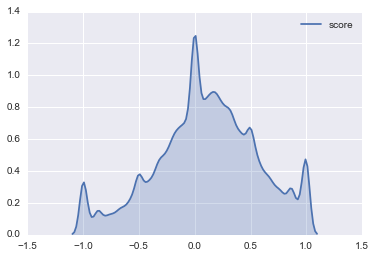

In [132]:
sns.kdeplot(sim, shade=True)

In [137]:
top.beer_id.value_counts()

1904     190
355      186
56973    170
276      169
92       168
        ... 
16403     13
4355      13
1882      13
3637      13
16441     12
dtype: int64

In [140]:
sim.loc[1904].nlargest(10)

beer_2
617     0.813125
21      0.786629
325     0.776602
750     0.725000
272     0.661823
1796    0.650682
982     0.647806
1606    0.633333
682     0.617175
347     0.594322
Name: score, dtype: float64

In [142]:
df[df.beer_id.isin([1904, 617])]

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
304,6.5,617,195,Troubadour Blond Ale,Belgian Pale Ale,4.5,4.5,4.5,4.5,Jason,5.0,Presentation: Slender 11.2 oz brown euro styl...,2001-01-25 22:53:56
1553,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.0,4.0,4.0,4.0,mattmaples,5.0,This is a good winter / Stong ale. Real big f...,2001-11-03 17:56:36
1626,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,5.0,5.0,5.0,5.0,pbrian,5.0,This is why I drink beer. All year long is m...,2001-11-08 10:46:56
1641,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,5.0,4.0,5.0,5.0,John,5.0,Every year when Nov. rolls around one of the ...,2001-11-09 09:27:55
1643,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.0,4.0,4.0,4.0,Brent,5.0,Huge and hoppy. This year's edition seemed e...,2001-11-09 09:41:42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97006,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.5,4.5,4.0,4.5,bnuttz,4.0,"2003 edition of the Celebration Ale, in a 12 ...",2004-04-12 05:03:42
97035,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,3.5,4.0,3.5,3.5,GreenCard,4.0,"Appearance: hazelnut brown, good clarity, not...",2004-04-12 14:52:38
98329,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,4.0,4.0,4.0,4.0,longpondbeerman,4.5,"The 2003 bottle edition pours a lovely, bubbl...",2004-04-19 21:18:56
99571,6.8,1904,140,Sierra Nevada Celebration Ale,American IPA,5.0,4.5,4.5,4.0,Joey7F,5.0,WOW!! I am so stoked! I just turned 21 (end o...,2004-04-26 21:52:09


TODO: person side.
TODO: shrinkage

In [133]:
sim

beer_1  beer_2
6       5         0.001360
7       5         0.541936
        6         0.365374
9       5         0.645497
        6         0.065164
                    ...   
56973   47785     0.327276
        48050     0.075428
        51300    -0.044591
        51558    -0.239325
        51959     0.141093
Name: score, dtype: float64

In [417]:
X = df.set_index(['brewer_id','profile_name'], append=True).sort_index().review_overall

In [418]:
X.loc[slice(None), slice(None), 'stcules']

       brewer_id
0      10325        1.5
1      10325        3.0
2      10325        3.0
3      10325        3.0
1534   16604        4.0
                   ... 
98242  16536        4.5
98269  16536        3.5
98275  16536        3.5
98681  183          2.5
98871  183          3.0
Name: review_overall, dtype: float64

In [ ]:
pearson_sim()

In [61]:
def hm(x, y, **kwargs):
    ratings = np.arange(0, 5.5, .5)
    grid = (pd.concat([x, y], axis=1)
              .assign(n=1)
              .groupby([x.name, y.name]).n.sum()
              .unstack()
              .reindex(index=ratings, columns=ratings)
              .sort_index(ascending=False))
    sns.heatmap(grid, ax=plt.gca(), cbar=False, square=True)

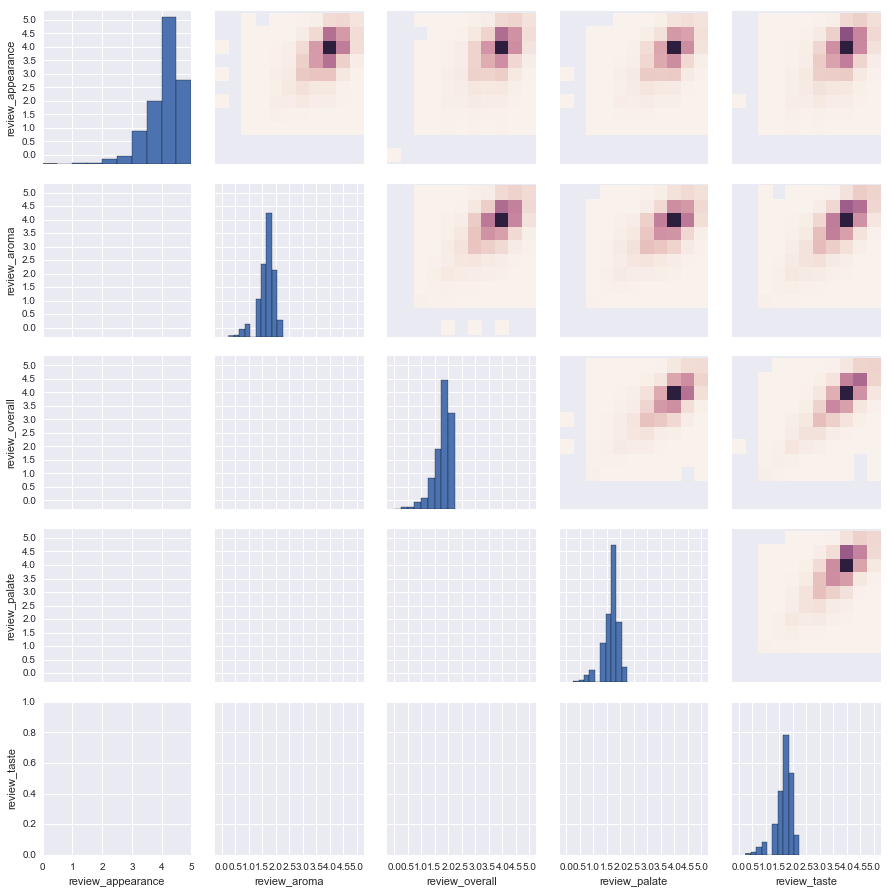

In [62]:
g = sns.PairGrid(df[review_cols])
g.map_upper(hm)
g.map_diag(plt.hist)

In [131]:
df.groupby(df.brewer_id.isin(ecclectic_brewers)).mean()

,abv,beer_id,brewer_id,review_appearance,review_aroma,review_overall,review_palate,review_taste
brewer_id,,,,,,,,
False,6.859996,23855.965276,3752.719210,3.753874,3.660576,3.733939,3.661322,3.697032
True,7.870967,28449.897874,3632.194312,4.054861,3.990960,4.029596,3.984891,4.066066


In [116]:
gr = df.groupby(['brewer_id', 'beer_style'])
f = gr.review_overall.agg(['mean', 'count'])

In [118]:
gr.agg(['mean', 'std', 'count'])

abv                      \
                                                mean           std count   
brewer_id beer_style                                                       
1          Baltic Porter                    7.000000  0.000000e+00     4   
           Czech Pilsener                   4.418392  1.339966e-01  1343   
           Euro Strong Lager                6.700000           NaN     6   
           Vienna Lager                     5.300000  0.000000e+00     4   
2          American Blonde Ale                   NaN           NaN     0   
           American Dark Wheat Ale               NaN           NaN     0   
           American IPA                          NaN           NaN     0   
           American Pale Ale (APA)               NaN           NaN     0   
           American Pale Wheat Ale               NaN           NaN     0   
           American Porter                       NaN           NaN     0   
           American Stout                        NaN           NaN     0   
           English Brown Ale                     NaN           NaN     0   
5          American Amber / Red Ale              NaN           NaN     0   
           American Blonde Ale              4.600000           NaN     1   
           American IPA                     5.000000  0.000000e+00    84   
           American Pale Ale (APA)          5.126882  9.684118e-02    93   
           English India Pale Ale (IPA)     4.200000  2.816263e-07    84   
           English Porter                   4.000000  0.000000e+00   121   
           Fruit / Vegetable Beer                NaN           NaN     0   
           Hefeweizen                            NaN           NaN     0   
           Herbed / Spiced Beer                  NaN           NaN     0   
           Russian Imperial Stout           6.000000  0.000000e+00    86   
           Scottish Ale                     4.700000  2.018952e-07    85   
           Winter Warmer                         NaN           NaN     0   
14         Altbier                          4.900000  0.000000e+00     2   
           American Amber / Red Ale         4.919118  5.322927e-01    34   
           American Barleywine             11.475610  1.090424e-01    41   
           American Brown Ale               6.300000  9.733398e-08     3   
           American Double / Imperial IPA   9.000000  0.000000e+00    32   
           American IPA                     6.579592  3.906007e-01    98   
...                                              ...           ...   ...   
26946      American Malt Liquor             7.000000  0.000000e+00     8   
26983      English Porter                   4.800000           NaN     1   
26990      American Amber / Red Ale         5.000000  0.000000e+00     3   
           American Black Ale              10.000000           NaN     1   
           American Double / Imperial IPA   8.850000  0.000000e+00     4   
           American IPA                     7.200000  0.000000e+00     2   
           American Pale Ale (APA)          5.500000           NaN     1   
           American Porter                  6.200000  0.000000e+00     6   
           Winter Warmer                    5.850000  1.909188e+00     2   
27021      American Amber / Red Ale              NaN           NaN     0   
           American Blonde Ale                   NaN           NaN     0   
           American IPA                          NaN           NaN     0   
           American Porter                  6.900000           NaN     1   
           Tripel                           8.900000           NaN     1   
27079      American Blonde Ale              5.500000           NaN     1   
27080      Scottish Ale                     3.900000  0.000000e+00     2   
27133      American IPA                     5.900000           NaN     1   
27136      American Pale Ale (APA)          4.800000  0.000000e+00     2   
27361      English Bitter                   3.900000           NaN     1   
27632      American A

In [95]:
styles = ['ipa|india pale ale', 'amber ale', 'stout', 'barleywine', 'porter', 'brown ale', 'lager']

In [96]:
expr = '|'.join([r'(?P<{name}>{x})'.format(name=x.split('|')[0].replace(' ', '_'), x=x) for x in styles])
expr

'(?P<ipa>ipa|india pale ale)|(?P<amber_ale>amber ale)|(?P<stout>stout)|(?P<barleywine>barleywine)|(?P<porter>porter)|(?P<brown_ale>brown ale)|(?P<lager>lager)'

In [104]:
style = df.beer_style.str.extract(expr, flags=re.IGNORECASE)

In [109]:
style = style.fillna('').sum(1)
style

0              
1              
2         Stout
3              
4           IPA
5              
6              
7              
8              
9              
10             
11             
12             
13             
14        Stout
15        Stout
16        Lager
17             
18             
19             
20             
21             
22             
23             
24             
25             
26             
27             
28             
29             
          ...  
199970         
199971         
199972         
199973         
199974         
199975         
199976         
199977         
199978         
199979         
199980         
199981         
199982         
199983         
199984         
199985         
199986         
199987         
199988         
199989         
199990         
199991         
199992         
199993         
199994         
199995         
199996         
199997         
199998         
199999         
dtype: object

In [112]:
gr = df.groupby(style).review_overall

In [61]:
df.beer_style.value_counts()

 American IPA                           24797
 American Double / Imperial Stout       18077
 American Double / Imperial IPA         13590
 American Pale Ale (APA)                 9971
 American Porter                         6769
 American Amber / Red Ale                5701
 American Barleywine                     5589
 Russian Imperial Stout                  4568
 Rye Beer                                4220
 Fruit / Vegetable Beer                  4021
 English Pale Ale                        3988
 Hefeweizen                              3822
 Scotch Ale / Wee Heavy                  3784
 Saison / Farmhouse Ale                  3468
 American Brown Ale                      3367
 American Strong Ale                     3352
 Czech Pilsener                          3211
 Euro Pale Lager                         2955
 American Pale Wheat Ale                 2788
 American Stout                          2669
 Old Ale                                 2664
 Extra Special / Strong Bitter (ES

In [4]:
ecclectic_brewers = df.groupby(['brewer_id']).beer_style.nunique().nlargest(20).index

In [56]:
f

mean  count
brewer_id beer_style                                      
1          Baltic Porter                   4.125000      4
           Czech Pilsener                  3.821668   1343
           Euro Strong Lager               3.416667      6
           Vienna Lager                    3.625000      4
2          American Blonde Ale             3.750000      2
           American Dark Wheat Ale         2.187500      8
           American IPA                    4.166667      3
           American Pale Ale (APA)         4.000000      3
           American Pale Wheat Ale         3.083333      6
           American Porter                 2.416667      6
           American Stout                  3.700000     10
           English Brown Ale               3.500000      2
5          American Amber / Red Ale        3.794118     17
           American Blonde Ale             4.000000      1
           American IPA                    3.702381     84
           American Pale Ale (APA)         3.766667    105
           English India Pale Ale (IPA)    3.250000     84
           English Porter                  4.053719    121
           Fruit / Vegetable Beer          3.000000      1
           Hefeweizen                      3.411458     96
           Herbed / Spiced Beer            3.500000      2
           Russian Imperial Stout          3.709302     86
           Scottish Ale                    3.394118     85
           Winter Warmer                   3.815217     46
14         Altbier                         4.000000      2
           American Amber / Red Ale        3.735294     34
           American Barleywine             4.207317     41
           American Brown Ale              4.333333      3
           American Double / Imperial IPA  4.078125     32
           American IPA                    4.142157    102
...                                             ...    ...
26946      American Malt Liquor            3.125000      8
26983      English Porter                  3.500000      1
26990      American Amber / Red Ale        4.166667      3
           American Black Ale              4.000000      1
           American Double / Imperial IPA  4.125000      4
           American IPA                    4.750000      2
           American Pale Ale (APA)         3.500000      1
           American Porter                 4.166667      6
           Winter Warmer                   4.000000      2
27021      American Amber / Red Ale        3.750000      2
           American Blonde Ale             4.250000      2
           American IPA                    4.125000      4
           American Porter                 4.000000      1
           Tripel                          3.500000      1
27079      American Blonde Ale             4.000000      1
27080      Scottish Ale                    3.500000      2
27133      American IPA                    4.000000      1
27136      American Pale Ale (APA)         3.500000      2
27361      English Bitter                  3.500000      1
27632      American Amber / Red Ale        4.000000      2
           American Blonde Ale             3.000000      1
           American IPA                    4.000000      1
           American Pale Ale (APA)         3.000000      1
           Baltic Porter                   4.000000      1
           English Bitter                  3.000000      1
           English India Pale Ale (IPA)    4.000000      1
           Russian Imperial Stout          4.500000      1
27645      American Pale Ale (APA)         4.500000      1
27797      American Pale Lager             3.250000      4
           Light Lager                     3.250000      2

[5289 rows x 2 columns]

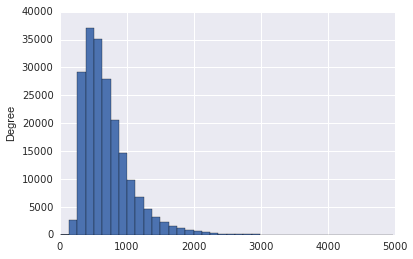

In [16]:
df.text.str.len().plot(kind='hist', bins=40)

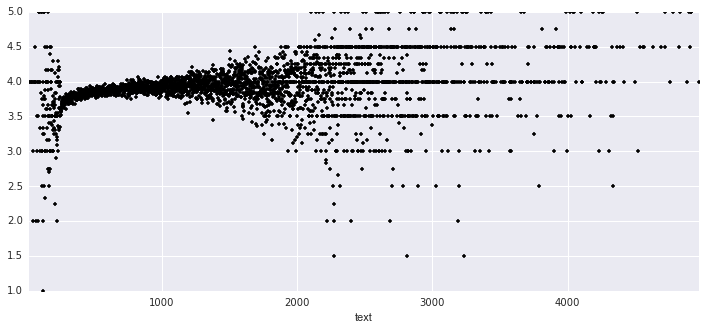

In [23]:
df.groupby(df.text.str.len()).review_overall.mean().plot(style='k.', figsize=(12, 5))

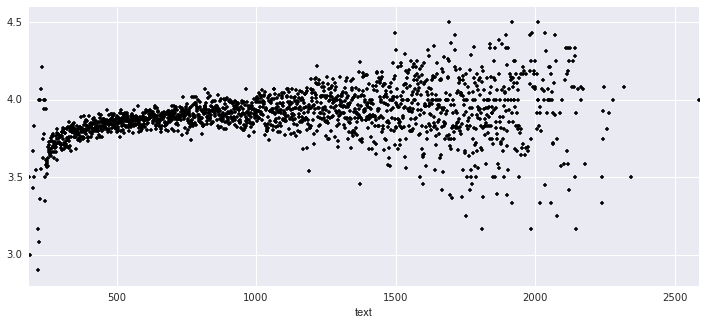

In [36]:
ax = (df.groupby(df.text.str.len())
   .review_overall.agg(['mean', 'std', 'count'])
   .query('count > 5')['mean']
   .plot(style='k.', figsize=(12, 5))
 )

In [39]:
df.text.str.split().apply(len)

TypeError: object of type 'float' has no len()

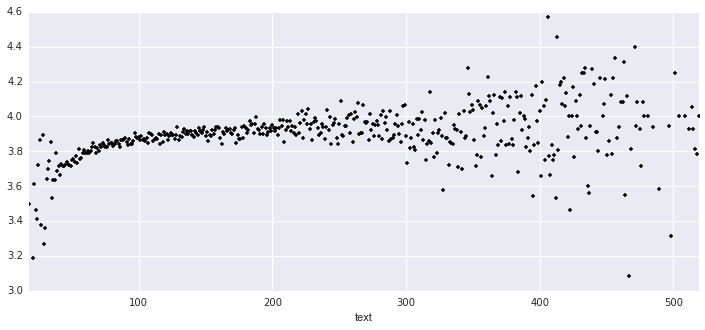

In [42]:
ax = (df.groupby(df.text.str.count(' '))
   .review_overall.agg(['mean', 'std', 'count'])
   .query('count > 5')['mean']
   .plot(style='k.', figsize=(12, 5))
 )

In [29]:
import statsmodels.api as sm

In [30]:
y = sm.nonparametric.lowess(df.review_overall, df.text.str.len())

In [33]:
import matplotlib.pyplot as plt

In [104]:
%matplotlib inline

from itertools import islice
from toolz import partitionby

import numpy as np
import pandas as pd

pd.options.display.max_rows = 10

In [36]:
f = open('../data/beeradvocate.txt')
f.readlines(545)

['beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n',
 '\n',
 'beer/name: Red Moon\n']

In [48]:
f.seek(0)
reviews = filter(lambda x: x != ('\n',), partitionby(lambda x: x == '\n', f))

In [49]:
review = next(reviews)
review

('beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n')

In [55]:
!wc -l ../data/beeradvocate.txt

 22212596 ../data/beeradvocate.txt


In [136]:
def to_json(reviews, i):
    with open('reviews-{}.json'.format(i), 'w') as f:
        json.dump(reviews, f)

In [137]:
with open('../data/beeradvocate.txt') as f:
    reviews = filter(lambda x: x != ('\n',),
                     partitionby(lambda x: x == '\n', f))
    reviews = map(format_review, reviews)
    reviews = partition(10000, reviews, pad=None)
    reviews = filter(None, reviews)
    for i, subset in enumerate(reviews):
        to_json(subset, i)
        print(i, end='\r')



In [127]:
# %load ../data/parse_beer.py
from itertools import islice

import pandas as pd
from toolz import partitionby, partition


def format_review(review):
    return dict(map(lambda x: x.strip().split(":", 1), review))

with open('../data/beeradvocate.txt') as f:
    reviews = filter(lambda x: x != ('\n',),
                     partitionby(lambda x: x == '\n', f))
    reviews = map(format_review, reviews)
    subset = islice(reviews, 100000)
    df = pd.DataFrame(list(subset))


col_names = {
    'beer/ABV': 'abv',
    'beer/beerId': 'beer_id',
    'beer/brewerId': 'brewer_id',
    'beer/name': 'beer_name',
    'beer/style': 'beer_style',
    'review/appearance': 'review_appearance',
    'review/aroma': 'review_aroma',
    'review/overall': 'review_overall',
    'review/palate': 'review_palate',
    'review/profileName': 'profile_name',
    'review/taste': 'review_taste',
    'review/text': 'text',
    'review/time': 'time'
}

numeric = ['abv', 'review_appearance', 'review_aroma',
           'review_overall', 'review_palate', 'review_taste']
df = (df.rename(columns=col_names)
        .replace('', np.nan))
df[numeric] = df[numeric].astype(float)
df['time'] = pd.to_datetime(df.time.astype(int), unit='s')


In [96]:
import seaborn as sns

In [91]:
df[numeric] = df[numeric].astype(float)

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 13 columns):
abv                  97223 non-null float64
beer_id              100000 non-null object
brewer_id            100000 non-null object
beer_name            100000 non-null object
beer_style           100000 non-null object
review_appearance    100000 non-null float64
review_aroma         100000 non-null float64
review_overall       100000 non-null float64
review_palate        100000 non-null float64
profile_name         99985 non-null object
review_taste         100000 non-null float64
text                 99975 non-null object
time                 100000 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 10.7+ MB


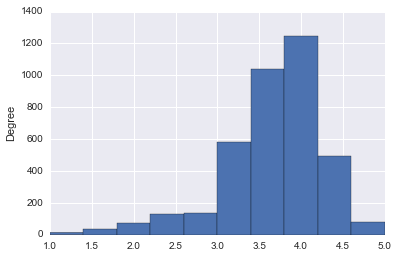

In [110]:
df.groupby('beer_id').review_overall.mean().plot(kind='hist', bins=10)

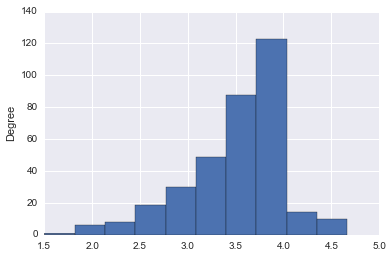

In [111]:
df.groupby('brewer_id').review_overall.mean().plot(kind='hist', bins=10)

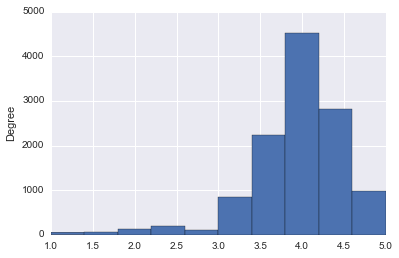

In [113]:
df.groupby('profile_name').review_overall.mean().plot(kind='hist', bins=10)

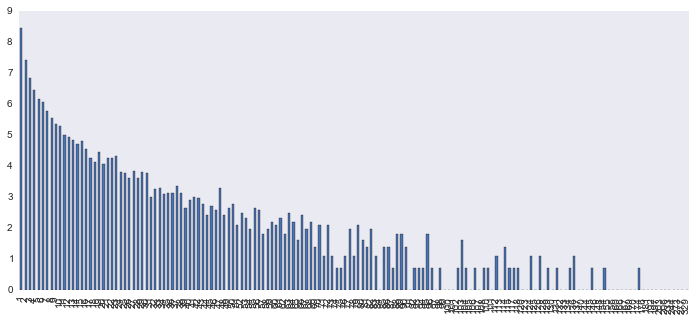

In [123]:
df.profile_name.value_counts().value_counts().sort_index().pipe(np.log).plot(kind='bar', grid=False, figsize=(12, 5))

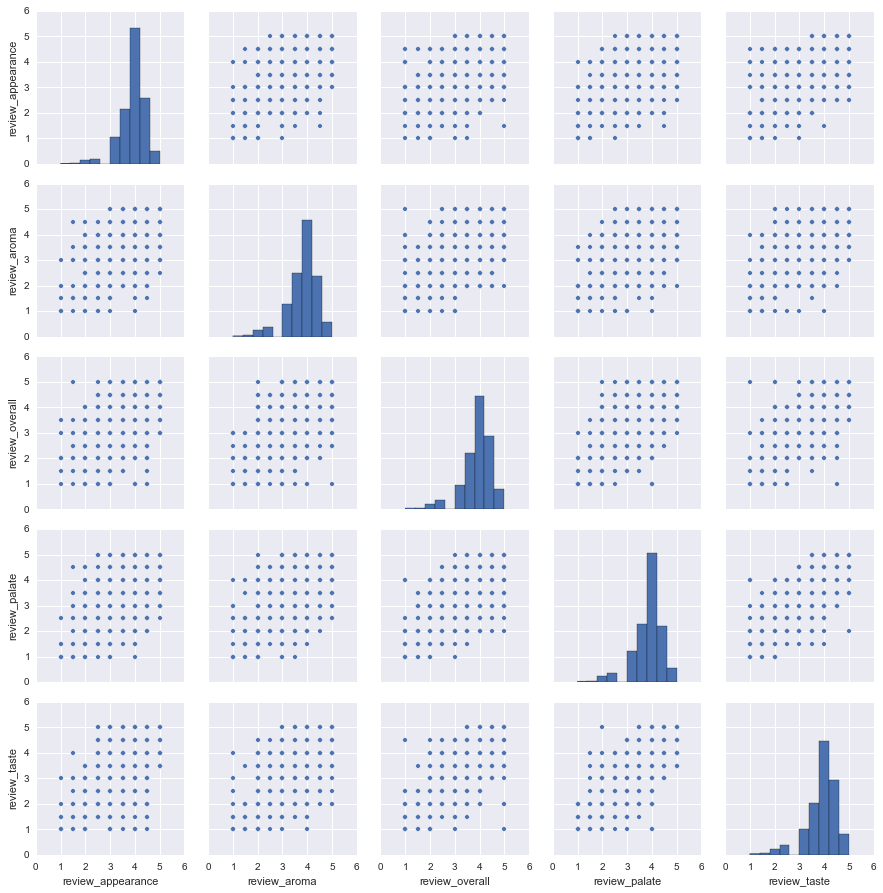

In [102]:
sns.pairplot(df.sample(5000),
             vars=['review_appearance', 'review_aroma', 'review_overall', 'review_palate', 'review_taste'])

In [56]:
import dask.dataframe as dd
df = dd.read_csv('../data/beer_reviews/*.csv')
counts = df.profile_name.value_counts().compute().nlargest(100)
top_users = counts.nlargest(100)
top_users
%time
top = df[df.profile_name.isin(top_users.index)].compute()
top.to_csv('top_users_beer.csv', index=False)
top = pd.read_csv('top_users_beer.csv')
top.head()
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']
cols = ['beer_name', 'beer_style', 'profile_name']
top[cols] = top[cols].apply(lambda x: x.str.strip())
top.profile_name.value_counts().plot(kind='hist', color='k')